In [ ]:
# import libraries
import json
import math
import os
from glob import glob 
from tqdm import tqdm
from PIL import Image
import cv2 # image processing
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization


from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop, Adamax
from keras.applications import ResNet50
from keras.utils.np_utils import to_categorical
from keras.layers import  Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator,image,img_to_array,load_img

In [ ]:
input_dir = "../input/chest-xray-pneumonia/chest_xray/"
train_dir = input_dir +"train/"
test_dir = input_dir +"test/"
val_dir = input_dir +"val/"

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(15,7))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['train','test','val']):
    set_path = input_dir+_set
    ax[i].axis('off')
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]))
    ax[i].set_title('File: {} - Condition: Healthy'.format(_set))
    ax[i+3].axis('off')
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]))
    ax[i+3].set_title('File: {} - Condition: Infected'.format(_set))

In [68]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,
                                       zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
    
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=train_dir, 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary')

    test_gen = test_val_datagen.flow_from_directory(
    directory=test_dir, 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary')
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(test_dir + cond)):
            img = plt.imread(test_dir+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels


In [78]:
img_dims = 150
batch_size = 20
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
# validation_generator = test_datagen.flow_from_directory(
#         val_dir,
#         target_size=(150, 150),
#         batch_size=20,
#         class_mode='binary')

In [ ]:
# Create ResNet50 Model with Keras library

#adamax = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax", **kwargs)

# Create ResNet50 Model with Keras library
resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())
    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation="sigmoid"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adamax(lr=lr),
        metrics=['acc']
    )
    return model

model = build_model(resnet ,lr = 1e-4)
model.summary()

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

# Fit Model
history2 = model.fit_generator(
    train_generator,
    steps_per_epoch=250,
    epochs=25,
    validation_data=test_generator,
    validation_steps=10,
    callbacks=[early_stopping_monitor]
)

In [34]:
# model save
model.save_weights("cnn-example-pneumonia-resnet50_bnorm_adamax_es_e4.h5")

In [37]:
history2.history

{'val_loss': [0.05997588485479355,
  0.01794246956706047,
  0.04141701012849808,
  0.07030805945396423],
 'val_acc': [0.9150000214576721,
  0.925000011920929,
  0.9449999928474426,
  0.9130434989929199],
 'loss': [0.08274287283006725,
  0.07491615596410033,
  0.05738797043575074,
  0.06775759135259597],
 'acc': [0.9703763, 0.9707766, 0.9783827, 0.97477984]}

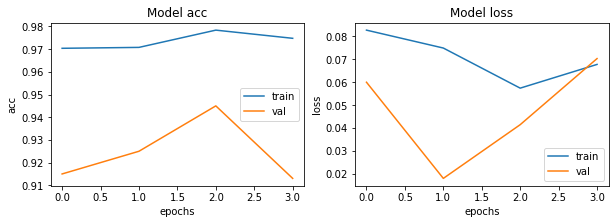

In [38]:
# Visualize Loss and Accuracy Rates
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

CONFUSION MATRIX ------------------


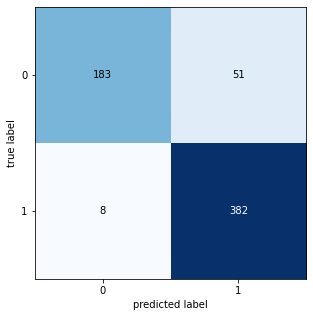


TEST METRICS ----------------------
Accuracy: 90.5448717948718%
Precision: 88.2217090069284%
Recall: 97.94871794871794%
F1-score: 92.83110571081409

TRAIN METRIC ----------------------
Train acc: 97.48


In [75]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX')
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()
# print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history2.history['acc'][-1])*100, 2)))

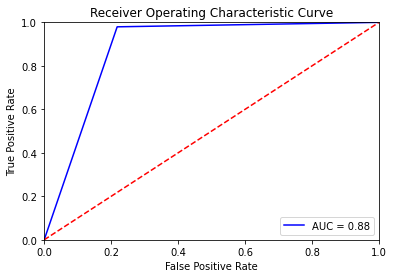

In [76]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(test_labels, np.round(preds))
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Trying with Variable Learning Rate, EarlyStopping Monitoring and More Epochs

In [79]:
# Create ResNet50 Model with Keras library
resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())
    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation="sigmoid"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adamax(lr=lr),
        metrics=['acc']
    )
    return model

model = build_model(resnet ,lr = 1e-4)
model.summary()

/opt/conda/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 5, 2048)        8192      
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 1001      
Total params: 25,645,905
Trainable params: 25,588,689
Non-trainable params: 57,216
____________________________________

In [85]:
# Creating model and compiling
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [ ]:
epochs = 25
batch_size = 20

hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/25
260/260 [==============================] - 187s 719ms/step - loss: 0.0862 - acc: 0.9671 - val_loss: 0.5832 - val_acc: 0.7613
Epoch 2/25
260/260 [==============================] - 179s 687ms/step - loss: 0.0758 - acc: 0.9717 - val_loss: 0.1814 - val_acc: 0.9089
Epoch 3/25
260/260 [==============================] - 176s 677ms/step - loss: 0.0684 - acc: 0.9775 - val_loss: 0.2028 - val_acc: 0.9288

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
Epoch 4/25
260/260 [==============================] - 174s 670ms/step - loss: 0.0680 - acc: 0.9763 - val_loss: 0.0322 - val_acc: 0.9288
Epoch 5/25
260/260 [==============================] - 175s 671ms/step - loss: 0.0523 - acc: 0.9823 - val_loss: 0.0327 - val_acc: 0.9354

Epoch 00005: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
Epoch 6/25
260/260 [==============================] - 173s 664ms/step - loss: 0.0565 - acc: 0.9800 - val_loss: 0.1408 - val_acc: 0.9272
Epoch 7/25
260/260 [=

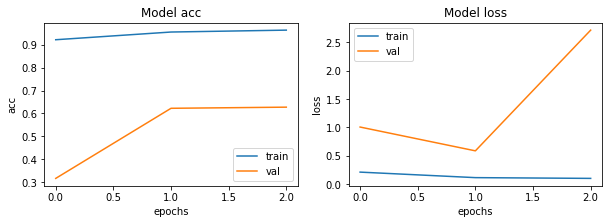

In [82]:
# Visualize Loss and Accuracy Rates
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX')
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()
# print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history2.history['acc'][-1])*100, 2)))

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(test_labels, np.round(preds))
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()